This notebook compares the accuracy of multiple data driven ROM methods on the full assembly

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster




import opinf


config = dotenv_values(".env")
from util import *

In [2]:
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

In [3]:
client.cluster

In [4]:
# Set up hyperparameters for all ROMs
n_timesteps = 200 # Number of timesteps to pull from each episode
dt = 0.001
n_train = 5 # Number of training episodes
n_test = 25 # Number of testing episodes
n_ROM = 12 # Dimension of ROM state space

# Read Data

In [5]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/threeSegmentData200Timesteps/"



In [6]:
# Read in all training data 
data = h5py.File(filepath+ "processedDataSet.hdf5", 'r')
print("gothere")
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))
x0 = data["stateData"][:,0,0]
y0 = data["reducedCenterlineData"][:,0,0]


# del data # free up memory
print("gothere2")
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
print("gothere3")
# del data # free up memory
# Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,n_train+n_test))
Y0 = da.zeros((m,n_train+n_test))
for i in range(n_train+n_test):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done")

gothere
gothere2
gothere3
Done


In [7]:
x0.shape

(226941,)

In [8]:
# Get length of robot from min and max of x coords
xzCoords = Y0[:,0].reshape(-1,2)

x_min = np.min(xzCoords[:,0])
x_max = np.max(xzCoords[:,0])
length = x_max - x_min
print("Length of robot: ", length.compute())
# Get z min and max
z_min = np.min(xzCoords[:,1])
z_max = np.max(xzCoords[:,1])


Length of robot:  1.3213038304049292


In [9]:
# Print shapes of data
print("Shape of X_fom: ", X_fom.shape)
print("Shape of U_fom: ", U_fom.shape)
print("Shape of Y_fom: ", Y_fom.shape)

Shape of X_fom:  (226941, 200, 30)
Shape of U_fom:  (6, 200, 30)
Shape of Y_fom:  (40, 200, 30)


# Learn System Matrices for Each Method

## SVD to find correct size of bases

In [10]:
# Compute SVD of state training set to find size of reduced basis
# Unroll the state training set into a matrix
X_fom_train_da = da.hstack([X_fom[:,:,i] for i in range(n_train)])
# Get shape of state training set
print(X_fom_train_da.shape)
X_fom_train_da

(226941, 1000)


dask.array<concatenate, shape=(226941, 1000), dtype=float64, chunksize=(4096, 200), chunktype=numpy.ndarray>

In [11]:
# compute singular values of unrolled state training set
U_fom_train_da, S_fom_train_da, V_fom_train_da = da.linalg.svd_compressed(X_fom_train_da, 1000)  
# Compute normalized singular values
S_fom_train_norm = S_fom_train_da / da.sum(S_fom_train_da)


In [12]:
S_fom_train_norm


dask.array<truediv, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [13]:
S_fom_train_norm = S_fom_train_norm.compute()


[0.41628285 0.60235597 0.68671233 0.75361738 0.81020933 0.84420533
 0.87052932 0.89344814 0.90884105 0.92239336 0.93196592 0.93913981
 0.94532931 0.94971425 0.95352302 0.957053   0.96005295 0.96283292
 0.96528543 0.96761069 0.96975915 0.97182191 0.97346764 0.97495021
 0.976399   0.97777904 0.97910923 0.98036984 0.98140012 0.98240794
 0.98335072 0.984222   0.9850302  0.98579234 0.98648668 0.98713784
 0.98776349 0.98835373 0.98890037 0.98941732 0.98990662 0.99037896
 0.99081557 0.99122513 0.99160991 0.99198777 0.99232382 0.99264457
 0.9929543  0.99323687 0.99350192 0.99375292 0.9939895  0.99422492
 0.99444833 0.99466373 0.99487137 0.99506305 0.99524958 0.99542839
 0.99559222 0.99574015 0.99587703 0.99601173 0.99614219 0.99626696
 0.99638969 0.99650025 0.99660561 0.99670659 0.99680622 0.99690545
 0.99699907 0.9970858  0.99716761 0.99724569 0.99732198 0.99739414
 0.9974653  0.99753604 0.99760507 0.99766931 0.99773212 0.99779322
 0.99785135 0.99790634 0.99795951 0.99801066 0.99806121 0.9981

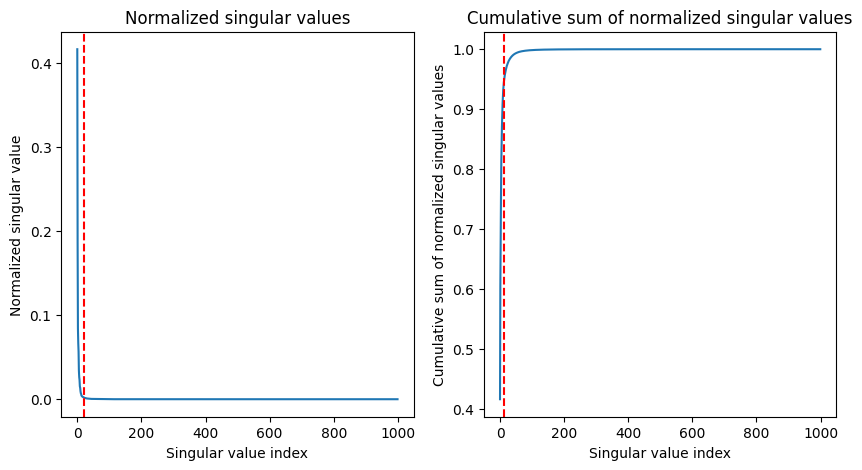

In [14]:
# Plot normalized singular values and the cumulative sum of normalized singular values
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(S_fom_train_norm)
plt.title('Normalized singular values')
plt.xlabel('Singular value index')
plt.ylabel('Normalized singular value')
plt.axvline(x=22, color='r', linestyle='--')

plt.subplot(1,2,2)
plt.plot(np.cumsum(S_fom_train_norm))
plt.title('Cumulative sum of normalized singular values')
plt.xlabel('Singular value index')
plt.ylabel('Cumulative sum of normalized singular values')
# Plot a vertical line at 22
plt.axvline(x=12, color='r', linestyle='--')

print(np.cumsum(S_fom_train_norm))


In [ ]:
n_ROM = 12 # Dimensionality of state in ROM

## OKID + ERA 

### Setup Data matrices  

In [16]:
# Grab input-output data from single episode 
U_era = U_fom[:,:,0]
Y_era = Y_fom[:,:,0]
# # Center output data around initial conditions
# Y_offset_era = Y_era[:,0].reshape(-1,1)
# Y_era = Y_era - Y_offset_era



### OKID Algorithm 

In [17]:
YY = Y_era
UU_size = (U_era.shape[0]*U_era.shape[1],U_era.shape[1])
UU = da.zeros(UU_size)

for i in range(U_era.shape[1]):
    startRow = i*U_era.shape[0]
    endRow = (i+1)*U_era.shape[0]
    UU[startRow:endRow,i:] = U_era[:,0:(U_era.shape[1]-i)]

# compute pseudoinverse of input matrix using SVD
U_UU, S_UU, Vh_UU = da.linalg.svd(UU)
UU_pinv = da.matmul(da.transpose(Vh_UU),da.matmul(da.diag(1/S_UU),da.transpose(U_UU)))
# UU_pinv = da.linalg.pinv(UU)
# Solve for impulse response  
IR = da.matmul(YY,UU_pinv)

# IR = da.linalg.lstsq(da.transpose(YY),da.transpose(UU)) # solves for transpose of impulse response

# IR = da.transpose(IR) # transpose to get impulse response


In [18]:
# Compute things to limit growth of computation graph
IR = IR.compute()
print(IR.shape)
# IR = da.from_array(IR)
print("done")

(40, 1200)
done


### Eigensystem Realization Algorithm

In [19]:
# Form Hankel matrix for ERA 
N = int(n_timesteps/2-1)
H_size = (m*N,l*N)

H = np.zeros(H_size)
Hprime = np.zeros(H_size)

for i in range(N):
    startRow = m*i 
    endRow = m*(i+1)
    H[startRow:endRow,:]=IR[:,l*(1+i):l*(1+i+N)]
    Hprime[startRow:endRow,:]=IR[:,l*(2+i):l*(2+i+N)]


In [20]:
IR.shape

(40, 1200)

In [21]:
H = da.from_array(H, chunks=(2048,H.shape[1]))
Hprime = da.from_array(Hprime, chunks=(2048,Hprime.shape[1]))
IR = da.from_array(IR, chunks=(IR.shape[0],4096))

In [22]:
# Get SVD of Hankel matrix
U, S, Vh = da.linalg.svd_compressed(H, 100)
# Vh = V.conj().T

In [23]:
# Print shapes of matrices
print("Shape of U: ", U.shape)
print("Shape of S: ", S.shape)
print("Shape of Vh: ", Vh.shape)

Shape of U:  (3960, 100)
Shape of S:  (100,)
Shape of Vh:  (100, 594)


In [24]:
# Truncate SVD
U = U[:,:n_ROM]
S = da.diag(S[:n_ROM])
Vh = Vh[:n_ROM,:]

In [25]:
# Print shapes of matrices
print("Shape of U: ", U.shape)
print("Shape of S: ", S.shape)
print("Shape of Vh: ", Vh.shape)

Shape of U:  (3960, 12)
Shape of S:  (12, 12)
Shape of Vh:  (12, 594)


In [26]:
# Compute trunacted SVD values
U, S, Vh = da.compute(U, S, Vh)
# S = S.compute()
# Vh = Vh.compute()

In [27]:
# Print sizes of SVD matrices
print("SVD matrices:")
print("U: ", U.shape)
print("S: ", S.shape)
print("V: ", Vh.shape)

SVD matrices:
U:  (3960, 12)
S:  (12, 12)
V:  (12, 594)


In [28]:
# Convert np arrays back into dask arrays
U = da.from_array(U)
Vh = da.from_array(Vh)
S = da.from_array(S)

In [29]:
# Solve for system matrices
Sigma_tilde_is = da.linalg.inv(da.sqrt(S)) # inverse squareroot of sigma matrix
Sigma_tilde_sqrt = da.sqrt(S) # squareroot of sigma matrix


Em = da.concatenate([da.eye(l),da.zeros((l*(N-1),l))],axis=0)
Ep = da.concatenate([da.eye(m),da.zeros((m*(N-1),m))],axis=0)

A_era = da.matmul(da.matmul(da.matmul(da.matmul(Sigma_tilde_is,da.transpose(U)),Hprime),da.transpose(Vh)),Sigma_tilde_is)
B_era = da.matmul(da.matmul(Sigma_tilde_sqrt,Vh),Em)
C_era = da.matmul(da.transpose(Ep),da.matmul(U,Sigma_tilde_sqrt))
D_era = IR[:,:l]


In [30]:
# A_era = A_era.compute()
# B_era = B_era.compute()
# C_era = C_era.compute()
# D_era = D_era.compute()

A_era, B_era, C_era, D_era = da.compute(A_era, B_era, C_era, D_era)

In [31]:
# Save system matrices, projection mappings, and initial offset into file for later use
np.savez(filepath+f"eraSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.npz", A_era=A_era, B_era=B_era, C_era=C_era, D_era=D_era, x0=x0, y0=y0)
# save as .mat file
scipy.io.savemat(filepath+f"eraSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.mat", mdict={'A_era': A_era, 'B_era': B_era, 'C_era': C_era, 'D_era': D_era, 'x0': x0, 'y0': y0})

In [32]:
# clean up memory except for system matrices
del U_era, Y_era, YY, UU, IR, H, Hprime, U, S, Vh, Sigma_tilde_is, Sigma_tilde_sqrt, Em, Ep


## DMDc

### Setup Data Matrices

In [34]:
# Initialize data matrices for training and testing
X_train = da.zeros((n,(n_timesteps-1)*n_train))#, chunks=(128,(n_timesteps-1)*n_train))
Xprime_train = da.zeros((n,(n_timesteps-1)*n_train))#, chunks=(128,(n_timesteps-1)*n_train))
Upsilon_train = da.zeros((l,(n_timesteps-1)*n_train))#, chunks=(l,512))
Y_train = da.zeros((m,(n_timesteps-1)*n_train))#, chunks=(m,128))
# Load in data from training episodes
for i in range(n_train):
    print(i)
    X_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,:-1,i]
    Xprime_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,1:,i]
    Upsilon_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = U_fom[:,:-1,i]
    Y_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = Y_fom[:,:-1,i]


0
1
2
3
4


In [35]:
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
# Omega = Omega.rechunk((Omega.shape[0],1))
# Omega


### Solve for Discrete Time System Matrices

In [36]:
# Decompose snapshot matrix using truncated SVD
p_dmd = 1024
r_dmd = n_ROM

U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd_compressed(Omega, p_dmd)
# Vh_tilde = da.conj(da.transpose(V_tilde))
Sigma_tilde = da.diag(Sigma_tilde)
U_hat, Sigma_hat, V_hat = da.linalg.svd_compressed(Xprime_train, r_dmd)
Sigma_hat = da.diag(Sigma_hat)



In [37]:
# Print shapes of svd matrices
print("U_tilde shape: ", U_tilde.shape)
print("Sigma_tilde shape: ", Sigma_tilde.shape)
print("Vh_tilde shape: ", Vh_tilde.shape)

U_tilde shape:  (226947, 995)
Sigma_tilde shape:  (995, 995)
Vh_tilde shape:  (995, 995)


In [38]:
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

In [39]:
# U_tilde_1.compute()

In [40]:
# Solve for system output matrix from full order system
ys = Y_train[:,0:10]

# compute approximate pseudoinverse of data matrix using SVD
# X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:10])
X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(S_X_train),da.transpose(U_X_train)))


# # X_PI = np.linalg.pinv(X_train[:,0:10])
C_dmdc = ys@X_PI
C_dmdc = C_dmdc@U_hat


In [41]:
# Print shape of svd matrices
print("Shape of U_X_train: ", U_X_train.shape)
print("Shape of S_X_train: ", S_X_train.shape)
print("Shape of Vh_X_train: ", Vh_X_train.shape)

Shape of U_X_train:  (226941, 10)
Shape of S_X_train:  (10,)
Shape of Vh_X_train:  (10, 10)


In [42]:
# Execute computations for dmdc system matrices
print("Computing System Matrices")
A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
# A_dmdc = A_dmdc.compute()
# print("Computing B_dmdc")
# B_dmdc = B_dmdc.compute()
# print("Computing C_dmdc")
# C_dmdc = C_dmdc.compute()
# print("Done")


Computing System Matrices


In [43]:
# Save system matrices, projection mappings, and initial offset into file for later use
np.savez(filepath+f"dmdcSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.npz", A_dmdc=A_dmdc, B_dmdc=B_dmdc, C_dmdc=C_dmdc, basis_dmdc = U_hat, x0=x0, y0=y0)
# save as .mat file
scipy.io.savemat(filepath+f"dmdcSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.mat", mdict={'A_dmdc': A_dmdc, 'B_dmdc': B_dmdc, 'C_dmdc': C_dmdc, 'basis_dmdc': U_hat, 'x0': x0, 'y0': y0})

In [44]:
# Clean up memory except for system matrices
del  Xprime_train, Upsilon_train, Omega, U_tilde, Sigma_tilde, Vh_tilde, Sigma_hat, V_hat, U_tilde_1, U_tilde_2, X_PI, ys

## LOpInf

In [46]:
# Read in continuous time operators from file
mat = scipy.io.loadmat(filepath+'lopinf_rom_r_6_operators.mat')
Bhat_lopinf = mat['Bhat']
Chat_lopinf = mat['Chat']
Ehat_lopinf = mat['Ehat']
Khat_lopinf = mat['Khat']
Mhat_lopinf = mat['Mhat']
basis_lopinf = mat['V']
# Form continuous time linear state space matrices
A_lopinf_ct = np.block([
    [np.zeros((n_ROM//2,n_ROM//2)),np.eye(n_ROM//2)],
    [-Khat_lopinf, -Chat_lopinf]
])
B_lopinf_ct = np.block([
    [np.zeros((n_ROM//2,l))],
    [Bhat_lopinf]
])
C_lopinf_ct = np.block([
    [Ehat_lopinf, np.zeros((m,n_ROM//2))]
])
D_lopinf_ct = np.zeros((m,l))
# Convert continuous time operators to discrete time operators
A_lopinf_dt = scipy.linalg.expm(A_lopinf_ct*dt)
B_lopinf_dt = (A_lopinf_dt-np.eye(n_ROM))@np.linalg.inv(A_lopinf_ct)@B_lopinf_ct
C_lopinf_dt = C_lopinf_ct
D_lopinf_dt = D_lopinf_ct

In [47]:
# Save system matrices, projection mappings, and initial offset into file for later use
np.savez(filepath+f"lopinfSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.npz", A_lopinf=A_lopinf_dt,B_lopinf=B_lopinf_dt,C_lopinf=C_lopinf_dt,D_lopinf = D_lopinf_dt,basis_lopinf = basis_lopinf, x0=x0, y0=y0)
# save as .mat file
scipy.io.savemat(filepath+f"dmdcSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.mat", mdict={'A_lopinf': A_lopinf_dt, 'B_lopinf': B_lopinf_dt, 'C_lopinf': C_lopinf_dt, 'D_lopinf': D_lopinf_dt, 'basis_lopinf':basis_lopinf, 'x0': x0, 'y0': y0})

# Save System Matrices for Control Experiments


In [48]:
# Save system matrices, projection mappings, and initial offset into file for later use
np.savez(filepath+f"romSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.npz", A_era=A_era, B_era=B_era, C_era=C_era, D_era=D_era, A_dmdc=A_dmdc, B_dmdc=B_dmdc, C_dmdc=C_dmdc, basis_dmdc = U_hat, A_lopinf=A_lopinf_dt,B_lopinf=B_lopinf_dt,C_lopinf=C_lopinf_dt,D_lopinf = D_lopinf_dt, x0=x0, y0=y0)
# save as .mat file
scipy.io.savemat(filepath+f"romSystemMatricesRefactor_{n_ROM}dim_{n_train}train_{n_test}test.mat", mdict={'A_era': A_era, 'B_era': B_era, 'C_era': C_era, 'D_era': D_era, 'A_dmdc': A_dmdc, 'B_dmdc': B_dmdc, 'C_dmdc': C_dmdc, 'basis_dmdc': U_hat, 'A_lopinf': A_lopinf_dt, 'B_lopinf': B_lopinf_dt, 'C_lopinf': C_lopinf_dt, 'D_lopinf': D_lopinf_dt, 'x0': x0, 'y0': y0})

# Verification Experiments

## Simulate System Responses from Training and Test Episodes

### OKID/ERA

In [49]:
# Initialize data matrices for training and testing responses
X_hat_rom_era = np.zeros((n_ROM,n_timesteps,n_train+n_test))
Y_hat_rom_era = np.zeros((m,n_timesteps,n_train+n_test))
U_fom = U_fom.compute()
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_era[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_era[:,[0],i] = C_era@X_hat_rom_era[:,[0],i] + D_era@U_fom[:,[0],i]


In [50]:
# Simulate ERA ROM for all episodes
for i in range(n_train+n_test):
    # Simulate ERA ROM
    for j in range(n_timesteps-1):
        X_hat_rom_era[:,[j+1],i] = A_era@X_hat_rom_era[:,[j],i] + B_era@U_fom[:,[j],i]
        Y_hat_rom_era[:,[j+1],i] = C_era@X_hat_rom_era[:,[j+1],i] + D_era@U_fom[:,[j+1],i]


In [51]:
# Uncenter output data with initial conditions for each episode
for i in range(n_train+n_test):
    Y_hat_rom_era[:,:,i] = Y_hat_rom_era[:,:,i] + Y0[:,i].reshape(m,1)


In [52]:
Y_hat_rom_era

array([[[-240.11200537, -240.11085604, -240.10442101, ...,
         -240.11200289, -240.11342892, -240.10912391],
        [-240.10139761, -240.10074811, -240.09780682, ...,
         -240.11869774, -240.11643231, -240.10433679],
        [-240.08134313, -240.09002462, -240.0876003 , ...,
         -240.11273697, -240.11792374, -240.09642698],
        ...,
        [-247.05056518, -237.23403351, -235.46319515, ...,
         -240.23434224, -242.70818733, -239.86097278],
        [-247.08511785, -237.26499863, -235.4479084 , ...,
         -240.19781046, -242.72849827, -239.86436243],
        [-247.11794675, -237.3041937 , -235.42289766, ...,
         -240.16146384, -242.74631409, -239.86335587]],

       [[-253.62594583, -253.62861789, -253.62179315, ...,
         -253.6204856 , -253.62240838, -253.62000879],
        [-253.6134996 , -253.61658739, -253.61164777, ...,
         -253.62401623, -253.61451158, -253.61628526],
        [-253.59706531, -253.61034101, -253.61013833, ...,
         -253.

In [53]:
# Clear some memory
del X_hat_rom_era

### DMDc

In [55]:
# Initialize data matrices for training and testing responses
X_hat_rom_dmdc = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_dmdc = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_dmdc = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_dmdc[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    # X_hat_fom_dmdc[:,[0],i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_dmdc[:,[0],i] = C_dmdc@X_hat_rom_dmdc[:,[0],i]

In [56]:
# Simulate DMDc ROM for all episodes
for i in range(n_train+n_test):
    # Simulate DMDc ROM
    for j in range(n_timesteps-1):
        X_hat_rom_dmdc[:,[j+1],i] = A_dmdc@X_hat_rom_dmdc[:,[j],i] + B_dmdc@U_fom[:,[j],i]
        # X_hat_fom_dmdc[:,[j+1],i] = U_hat@X_hat_rom_dmdc[:,[j+1],i] # Compute full order state from reduced order state
        Y_hat_rom_dmdc[:,[j+1],i] = C_dmdc@X_hat_rom_dmdc[:,[j+1],i]

In [57]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    # X_hat_fom_dmdc[:,:,i] = X_hat_fom_dmdc[:,:,i] + X0[:,i].reshape(n,1)
    Y_hat_rom_dmdc[:,:,i] = Y_hat_rom_dmdc[:,:,i] + Y0[:,i].reshape(m,1)

In [58]:
# Clear some memory
del X_hat_rom_dmdc, X_hat_fom_dmdc

### LOpInf

In [59]:
# Read in data from LOpInf Trials

# Read in data from LOpInf Trials hdf5 file
data = h5py.File(filepath+ "lopinf_rom_r_6.hdf5", 'r')
print("gothere")
Y_hat_rom_lopinf = da.from_array(data["outputData_approx"], chunks=(4096, 4096,1))
X_hat_rom_lopinf = da.from_array(data["stateData_approx"], chunks=(4096, 4096,1))




# mat = mat73.loadmat(filepath+'lopinf_rom_r_6.mat')
# X_hat_rom_lopinf = mat['stateData_approx']
# Y_hat_rom_lopinf = mat['outputData_approx']


gothere


In [60]:
del mat

In [61]:
# Also generate outputs from LOpInf discrete time model
# Initialize data matrices for training and testing responses
X_hat_rom_lopinf_dt = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_lopinf_dt = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_lopinf_dt = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_lopinf_dt[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    # X_hat_fom_lopinf_dt[:,[0],i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_lopinf_dt[:,[0],i] = C_lopinf_dt@X_hat_rom_lopinf_dt[:,[0],i]


In [62]:
# Simulate LOpInf discrete time ROM for all episodes
for i in range(n_train+n_test):
    # Simulate LOpInf discrete time ROM
    for j in range(n_timesteps-1):
        X_hat_rom_lopinf_dt[:,[j+1],i] = A_lopinf_dt@X_hat_rom_lopinf_dt[:,[j],i] + B_lopinf_dt@U_fom[:,[j],i]
        Y_hat_rom_lopinf_dt[:,[j+1],i] = C_lopinf_dt@X_hat_rom_lopinf_dt[:,[j+1],i]

In [63]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    Y_hat_rom_lopinf_dt[:,:,i] = Y_hat_rom_lopinf_dt[:,:,i] + Y0[:,i].reshape(m,1)

### Uncenter Full Order Model

In [68]:
# Read in all again data to get uncentered versions
data = h5py.File(filepath+ "processedDataSet.hdf5", 'r')
print("gothere")
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))

gothere


## Response Visualizations

In [69]:
t = np.arange(0,dt*n_timesteps,dt)

### First Output Response

#### Training Set 1

Text(0.5, 1.0, 'First Output from First Training Episode')

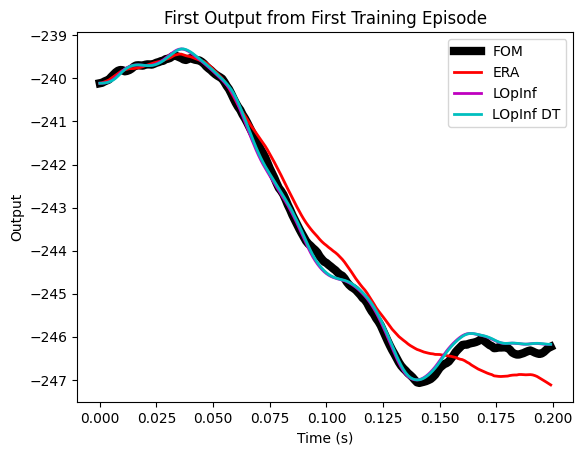

In [70]:
# Plot first output from first training episode for all modelling methods
plt.figure()
plt.plot(t,Y_fom[0,:,0],'k',label='FOM',linewidth=6)

plt.plot(t,Y_hat_rom_era[0,:,0],'r',label='ERA',linewidth=2)
# plt.plot(t,Y_hat_rom_dmdc[0,:,0],'b',label='DMDc',linewidth=5)
#plt.plot(t,Y_hat_rom_opInf[0,:,0],'g',label='OpInf',linewidth=5)
plt.plot(t,Y_hat_rom_lopinf[0,:,0],'m',label='LOpInf',linewidth=2)
plt.plot(t,Y_hat_rom_lopinf_dt[0,:,0],'c',label='LOpInf DT',linewidth=2)

legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('Output')
title = 'First Output from First Training Episode'
plt.title(title)

#### Test Set 1

In [ ]:
# Plot first output from first testing episode for all modelling methods
plt.figure()
plt.plot(t,Y_fom[0,:,n_train],'k',label='FOM',linewidth=5)
plt.plot(t,Y_hat_rom_era[0,:,n_train],'r',label='ERA',linewidth=2)
# plt.plot(t,Y_hat_rom_dmdc[0,:,n_train],'b',label='DMDc',linewidth=5)
# plt.plot(t,Y_hat_rom_opInf[0,:,n_train],'g',label='OpInf',linewidth=5)
plt.plot(t,Y_hat_rom_lopinf[0,:,n_train],'m',label='LOpInf',linewidth=2)
plt.plot(t,Y_hat_rom_lopinf_dt[0,:,n_train],'c',label='LOpInf DT',linewidth=2)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('Output')
title = 'First Output from First Testing Episode'
plt.title(title)


### First state Response

#### First Training Episode

In [ ]:
# Plot first state from first training episode for all modelling methods except ERA
plt.figure()
plt.plot(t,X_fom[0,:,0],'k',label='FOM',linewidth=5)
plt.plot(t,X_hat_fom_dmdc[0,:,0],'b',label='DMDc',linewidth=5)
# plt.plot(t,X_hat_fom_opInf[0,:,0],'g',label='OpInf',linewidth=5)
plt.plot(t,X_hat_rom_lopinf[0,:,0],'m',label='LOpInf',linewidth=5)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('State')
title = 'First State from First Training Episode'
plt.title(title)

#### First Test Episode

In [ ]:
# Plot first state from first testing episode for all modelling methods except ERA
plt.figure()
plt.plot(t,X_fom[0,:,n_train],'k',label='FOM',linewidth=5)
plt.plot(t,X_hat_fom_dmdc[0,:,n_train],'b',label='DMDc',linewidth=5)
#plt.plot(t,X_hat_fom_opInf[0,:,n_train],'g',label='OpInf',linewidth=5)
# plt.plot(t,X_hat_rom_lopinf[0,:,n_train],'m',label='LOpInf',linewidth=5)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('State')
title = 'First State from First Testing Episode'
plt.title(title)

### Centerline Videos

In [ ]:
# Setup save path for videos
video_path = config["currentDirectory"] +"data/videos/"
videoName_test = 'test_episode_3segment.mp4'
videoName_train = 'train_episode_3segment.mp4'
# Number of frames and playspeed for video
numFrames = n_timesteps
fps = 30
duration = numFrames/fps
# Axis limits for video
xlim_max = 400
xlim_min =  -300
zlim_max = -165
zlim_min = -315
ulim_max = 0.2
ulim_min = -0.2
# # Parameters for centerline reduction 
# n_seg = 10 # number of discrete points to use for centerline
# N_local = 20 # number of local points to use when averaging around each discrete point



#### Training Set 1

Generate animation of centerline motion using output data from all modelling methods for the first training set


In [ ]:
# Set up figure
fig, ax = plt.subplots()
# Define animation callback
def animate(t):
    # Bring in global variables for output data of fom and each method
    global Y_fom, Y_hat_rom_era, Y_hat_rom_dmdc, Y_hat_rom_opInf, Y_hat_rom_lopinf
    # Get frame index
    i = int(round(t*fps))
    # Reshape centerline data for each method for the given timestep of the first training episode
    centerline_fom = Y_fom[:,i,0].reshape(-1,2)
    centerline_era = Y_hat_rom_era[:,i,0].reshape(-1,2)
    centerline_dmdc = Y_hat_rom_dmdc[:,i,0].reshape(-1,2)
    #centerline_opInf = Y_hat_rom_opInf[:,i,0].reshape(-1,2)
    centerline_lopinf = Y_hat_rom_lopinf[:,i,0].reshape(-1,2)
    # Compute reduced centerlines for each method
    centerline_fom_red = centerline_fom
    centerline_era_red = centerline_era
    centerline_dmdc_red = centerline_dmdc
    centerline_lopinf_red = centerline_lopinf
    #centerline_opInf_red = reduceCenterline(n_seg,centerline_opInf,N_local)
    # centerline_lopinf_red = reduceCenterline(n_seg,centerline_lopinf,N_local)
    # Plot reduced centerlines
    ax.clear()
    ax.plot(centerline_fom_red[:,1],centerline_fom_red[:,0],'k',label='FOM',linewidth=5)
    ax.plot(centerline_era_red[:,1],centerline_era_red[:,0],'r',label='ERA',linewidth=5)
    ax.plot(centerline_dmdc_red[:,1],centerline_dmdc_red[:,0],'b',label='DMDc',linewidth=5)
    #ax.plot(centerline_opInf_red[:,0],centerline_opInf_red[:,1],'g',label='OpInf',linewidth=5)
    ax.plot(centerline_lopinf_red[:,1],centerline_lopinf_red[:,0],'m',label='LOpInf',linewidth=5)
    ax.set_xlim(xlim_min,xlim_max)
    ax.set_ylim(zlim_min,zlim_max)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_title('Centerline at timestep '+str(i))
    legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path+videoName_train, fps=fps)



#### Test Set 1

In [ ]:
# Set up figure
fig, ax = plt.subplots()
# Define animation callback 
def animate(t):
    # Bring in global variables for output data of fom and each method
    global Y_fom, Y_hat_rom_era, Y_hat_rom_dmdc, Y_hat_rom_opInf, Y_hat_rom_lopinf
    # Get frame index
    i = int(round(t*fps))
    # Reshape centerline data for each method for the given timestep of the first testing episode
    centerline_fom = Y_fom[:,i,n_train].reshape(-1,2)
    centerline_era = Y_hat_rom_era[:,i,n_train].reshape(-1,2)
    centerline_dmdc = Y_hat_rom_dmdc[:,i,n_train].reshape(-1,2)
    #centerline_opInf = Y_hat_rom_opInf[:,i,0].reshape(-1,2)
    centerline_lopinf = Y_hat_rom_lopinf[:,i,n_train].reshape(-1,2)
    # Compute reduced centerlines for each method
    centerline_fom_red = centerline_fom
    centerline_era_red = centerline_era
    centerline_dmdc_red = centerline_dmdc
    centerline_lopinf_red = centerline_lopinf
    #centerline_opInf_red = reduceCenterline(n_seg,centerline_opInf,N_local)
    # centerline_lopinf_red = reduceCenterline(n_seg,centerline_lopinf,N_local)
    # Plot reduced centerlines
    ax.clear()
    ax.plot(centerline_fom_red[:,1],centerline_fom_red[:,0],'k',label='FOM',linewidth=5)
    ax.plot(centerline_era_red[:,1],centerline_era_red[:,0],'r',label='ERA',linewidth=5)
    ax.plot(centerline_dmdc_red[:,1],centerline_dmdc_red[:,0],'b',label='DMDc',linewidth=5)
    #ax.plot(centerline_opInf_red[:,0],centerline_opInf_red[:,1],'g',label='OpInf',linewidth=5)
    ax.plot(centerline_lopinf_red[:,1],centerline_lopinf_red[:,0],'m',label='LOpInf',linewidth=5)
    ax.set_xlim(xlim_min,xlim_max)
    ax.set_ylim(zlim_min,zlim_max)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_title('Centerline at timestep '+str(i))
    legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path+videoName_test, fps=fps)



## Relative Error Computations

### Relative Output Errors

#### Training Episodes

In [ ]:
# Compute relative error in frobenius norm for all training episodes
rel_err_era_train = np.zeros((n_train,1))
rel_err_dmdc_train = np.zeros((n_train,1))
rel_err_opInf_train = np.zeros((n_train,1))
rel_err_lopinf_train = np.zeros((n_train,1))
for i in range(n_train):
    rel_err_era_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_era[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_dmdc_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_dmdc[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_lopinf_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_lopinf[:,:,i])/np.linalg.norm(Y_fom[:,:,i])

#### Test Episodes


In [ ]:
# Compute relative error in frobenius norm for all testing episodes
rel_err_era_test = np.zeros((n_test,1))
rel_err_dmdc_test = np.zeros((n_test,1))
rel_err_opInf_test = np.zeros((n_test,1))
rel_err_lopinf_test = np.zeros((n_test,1))
for i in range(n_test):
    rel_err_era_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_era[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_dmdc_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_dmdc[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_lopinf_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_lopinf[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])

In [ ]:
# Make bar plot with error bars for training and testing episodes for each method
fig, ax = plt.subplots()
ax.bar(np.arange(0,8,2)-0.45,[np.mean(rel_err_era_train),np.mean(rel_err_dmdc_train),np.mean(rel_err_opInf_train),np.mean(rel_err_lopinf_train)],yerr=[np.std(rel_err_era_train),np.std(rel_err_dmdc_train),np.std(rel_err_opInf_train),np.std(rel_err_lopinf_train)],color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,8,2)+0.45,[np.mean(rel_err_era_test),np.mean(rel_err_dmdc_test),np.mean(rel_err_opInf_test),np.mean(rel_err_lopinf_test)],yerr=[np.std(rel_err_era_test),np.std(rel_err_dmdc_test),np.std(rel_err_opInf_test),np.std(rel_err_lopinf_test)],color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
ax.set_ylabel('Relative error')
ax.set_xticks(np.arange(0,8,2))
ax.set_xticklabels(['ERA','DMDc','OpInf','LOpInf'])
ax.set_title('Relative output error for training and testing episodes')
ax.yaxis.grid(True)
ax.legend(['Training','Testing'])
# plt.tight_layout()


### Relative State Errors

In [ ]:
# Compute relative error in frobenius norm for all training episodes of full order states for each method except ERA
rel_err_dmdc_train_full = np.zeros((n_train,1))
rel_err_opInf_train_full = np.zeros((n_train,1))
rel_err_lopinf_train_full = np.zeros((n_train,1))
for i in range(n_train):
    rel_err_dmdc_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_fom_dmdc[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    rel_err_opInf_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_fom_opInf[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    # rel_err_lopinf_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_rom_lopinf[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    


In [ ]:
# Compute relative error in frobenius norm for all testing episodes of full order states for each method except ERA
rel_err_dmdc_test_full = np.zeros((n_test,1))
rel_err_opInf_test_full = np.zeros((n_test,1))
rel_err_lopinf_test_full = np.zeros((n_test,1))
for i in range(n_test):
    rel_err_dmdc_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_fom_dmdc[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])
    rel_err_opInf_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_fom_opInf[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])
    # rel_err_lopinf_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_rom_lopinf[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])



In [ ]:
# Make bar plot with error bars for training and testing episodes for each method
fig, ax = plt.subplots()
ax.bar(np.arange(0,6,2)-0.45,[np.mean(rel_err_dmdc_train_full),np.mean(rel_err_opInf_train_full),np.mean(rel_err_lopinf_train_full)],yerr=[np.std(rel_err_dmdc_train_full),np.std(rel_err_opInf_train_full),np.std(rel_err_lopinf_train_full)],color=['b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,6,2)+0.45,[np.mean(rel_err_dmdc_test_full),np.mean(rel_err_opInf_test_full),np.mean(rel_err_lopinf_test_full)],yerr=[np.std(rel_err_dmdc_test_full),np.std(rel_err_opInf_test_full),np.std(rel_err_lopinf_test_full)],color=['b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
ax.set_ylabel('Relative error')
ax.set_xticks(np.arange(0,6,2))
ax.set_xticklabels(['DMDc','OpInf','LOpInf'])
ax.set_title('Relative full state error for training and testing episodes')
ax.yaxis.grid(True)
ax.legend(['Training','Testing'])
# plt.tight_layout()

